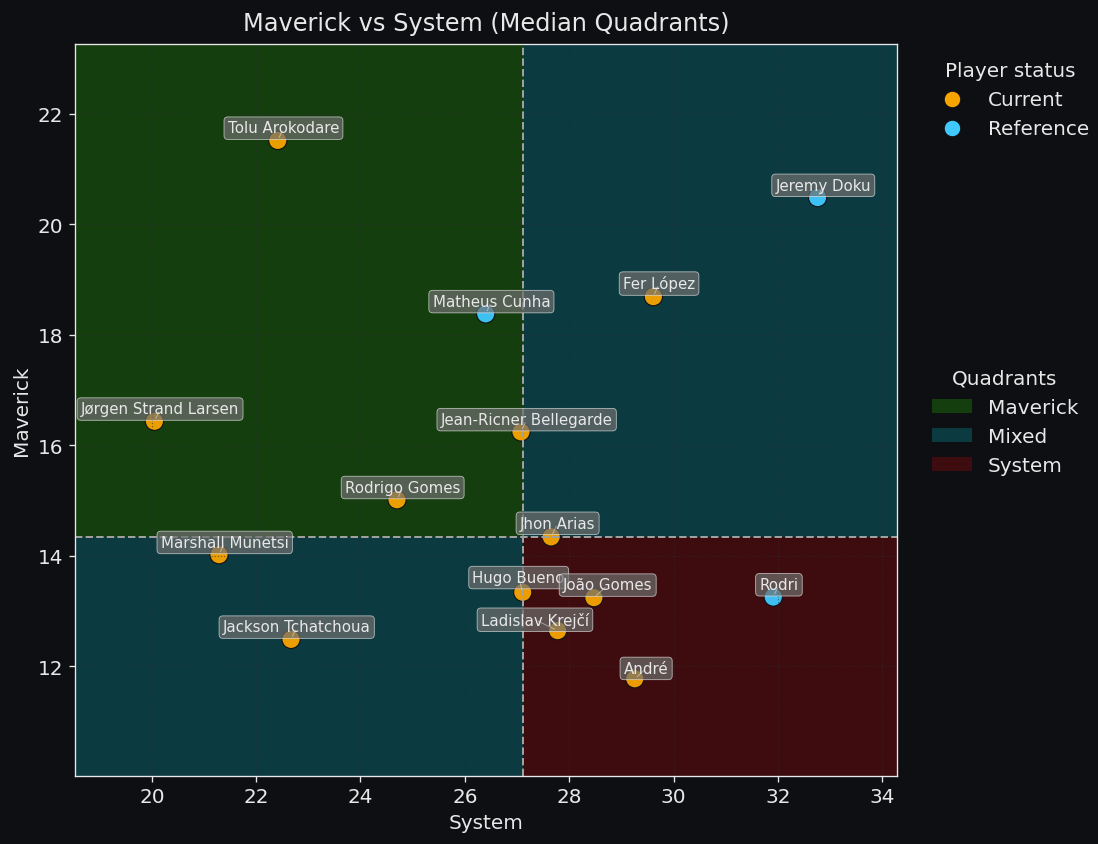

In [19]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D

try:
    from adjustText import adjust_text
    _USE_ADJUST_TEXT = True
except Exception:
    _USE_ADJUST_TEXT = False

FILE  = "cs6.xlsx"
SHEET = "FINAL"

LOGICAL_COLS = {
    "MAV_COL":  ["Maverick"],
    "SYS_COL":  ["System"],
    "STATE_COL":  ["State"],
    "PLAYER_COL": ["Name"]
}

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
CURR_COLOR = "#f7a400"
REF_COLOR = "#40c9ff"
REG_LINE_COLOR = "#a0a0a0"

def _norm(s: str) -> str:
    s = str(s)
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())
    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]
    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]
    if required:
        raise KeyError(
            f"Could not resolve a column for candidates {candidates}. "
            f"Available columns: {list(df.columns)}"
        )
    return None

if not os.path.exists(FILE):
    raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

df = pd.read_excel(FILE, sheet_name=SHEET)

resolved = {}
for logical, cands in LOGICAL_COLS.items():
    resolved[logical] = resolve_column(df, cands, required=True)

MAV_COL   = resolved["MAV_COL"]
SYS_COL  = resolved["SYS_COL"]
STATE_COL  = resolved["STATE_COL"]
PLAYER_COL = resolved["PLAYER_COL"]

work = df.copy()
work[MAV_COL]  = pd.to_numeric(work[MAV_COL], errors="coerce")
work[SYS_COL] = pd.to_numeric(work[SYS_COL], errors="coerce")
work = work.dropna(subset=[MAV_COL, SYS_COL, PLAYER_COL, STATE_COL])
work = work[work[SYS_COL] > 0].copy()

def _std_state(s):
    s = str(s).strip().lower()
    if s in {"current", "active", "on roster", "present"}:
        return "Current"
    if s in {"Reference", "left", "sold", "loaned", "released", "former"}:
        return "Reference"
    return s.title()

work[STATE_COL] = work[STATE_COL].apply(_std_state)
state_to_color = {"Current": CURR_COLOR, "Reference": REF_COLOR}
colors = work[STATE_COL].map(state_to_color).fillna(FG_COLOR).values

plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": BG_COLOR,
    "axes.facecolor": BG_COLOR,
    "axes.edgecolor": FG_COLOR,
    "axes.labelcolor": FG_COLOR,
    "xtick.color": FG_COLOR,
    "ytick.color": FG_COLOR,
    "text.color": FG_COLOR,
    "grid.color": GRID_COLOR,
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

x = work[SYS_COL].values
y = work[MAV_COL].values

x_med = np.median(x)
y_med = np.median(y)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xpad = (xmax - xmin) * 0.12 if xmax > xmin else 1.0
ypad = (ymax - ymin) * 0.18 if ymax > ymin else 1.0

ax.add_patch(Rectangle((xmin - xpad, y_med), (x_med - (xmin - xpad)), (ymax + ypad - y_med),
                       facecolor="#33ff00", alpha=0.2, edgecolor="none"))
ax.add_patch(Rectangle((x_med, y_med), (xmax + xpad - x_med), (ymax + ypad - y_med),
                       facecolor="#00eaff", alpha=0.2, edgecolor="none"))
ax.add_patch(Rectangle((xmin - xpad, ymin - ypad), (x_med - (xmin - xpad)), (y_med - (ymin - ypad)),
                       facecolor="#00eaff", alpha=0.2, edgecolor="none"))
ax.add_patch(Rectangle((x_med, ymin - ypad), (xmax + xpad - x_med), (y_med - (ymin - ypad)),
                       facecolor="#ff0000ff", alpha=0.2, edgecolor="none"))

ax.axvline(x_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)
ax.axhline(y_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)

ax.scatter(work[SYS_COL], work[MAV_COL], c=colors, s=120, edgecolors=BG_COLOR, linewidths=0.7, alpha=0.95)

texts = []
for _, r in work.iterrows():
    name = str(r[PLAYER_COL])
    xval, yval = r[SYS_COL], r[MAV_COL]

    ha, va = "center", "bottom"
    if name.lower().startswith("matheus cunha") or name.lower().startswith("matheus"):
        if xval > xmax - xpad * 0.5:
            ha = "right"
        if yval > ymax - ypad * 0.5:
            va = "top"

    texts.append(ax.text(
        xval, yval, name,
        fontsize=9, ha=ha, va=va, clip_on=True,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="#6f6f6f",
                  alpha=0.7, edgecolor=FG_COLOR, linewidth=0.5)
    ))

if _USE_ADJUST_TEXT and len(texts) > 0:
    adjust_text(
        texts, only_move={'points': 'y', 'text': 'xy'}, ax=ax,
        arrowprops=dict(arrowstyle="-", lw=0.6, color=FG_COLOR, alpha=0.5),
        expand_points=(1.1, 1.2), expand_text=(1.1, 1.2),
        force_points=0.2, force_text=0.2, lim=500
    )

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)
ax.set_xlabel("System")
ax.set_ylabel("Maverick")
ax.set_title("Maverick vs System (Median Quadrants)", pad=8)
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

h_cur = Line2D([0], [0], marker="o", color="none", markerfacecolor=CURR_COLOR, markeredgecolor=BG_COLOR,
               markeredgewidth=0.7, markersize=10, label="Current")
h_dep = Line2D([0], [0], marker="o", color="none", markerfacecolor=REF_COLOR, markeredgecolor=BG_COLOR,
               markeredgewidth=0.7, markersize=10, label="Reference")

leg_status = ax.legend(
    handles=[h_cur, h_dep],
    title="Player status",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0)
)
ax.add_artist(leg_status)

quad_handles = [
    Patch(facecolor="#33ff00", edgecolor="none", alpha=0.2, label="Maverick"),
    Patch(facecolor="#00eaff", edgecolor="none", alpha=0.2, label="Mixed"),
    Patch(facecolor="#ff0000ff", edgecolor="none", alpha=0.2, label="System"),
]

ax.legend(
    handles=quad_handles,
    title="Quadrants",
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 0.58)
)


# FOOTNOTE = "Maverick = Usage + Bias + Threat + Risk"
# FOOTNOTE2 = "System = Passes + Pass Completion % + Progression + Structure"

# fig.text(0.12, 0.04, FOOTNOTE, color="#9a9a9a", fontsize=9)
# fig.text(0.12, 0.02, FOOTNOTE2, color="#9a9a9a", fontsize=9)


plt.tight_layout(rect=[0.06, 0.04, 0.84, 0.94])
plt.show()


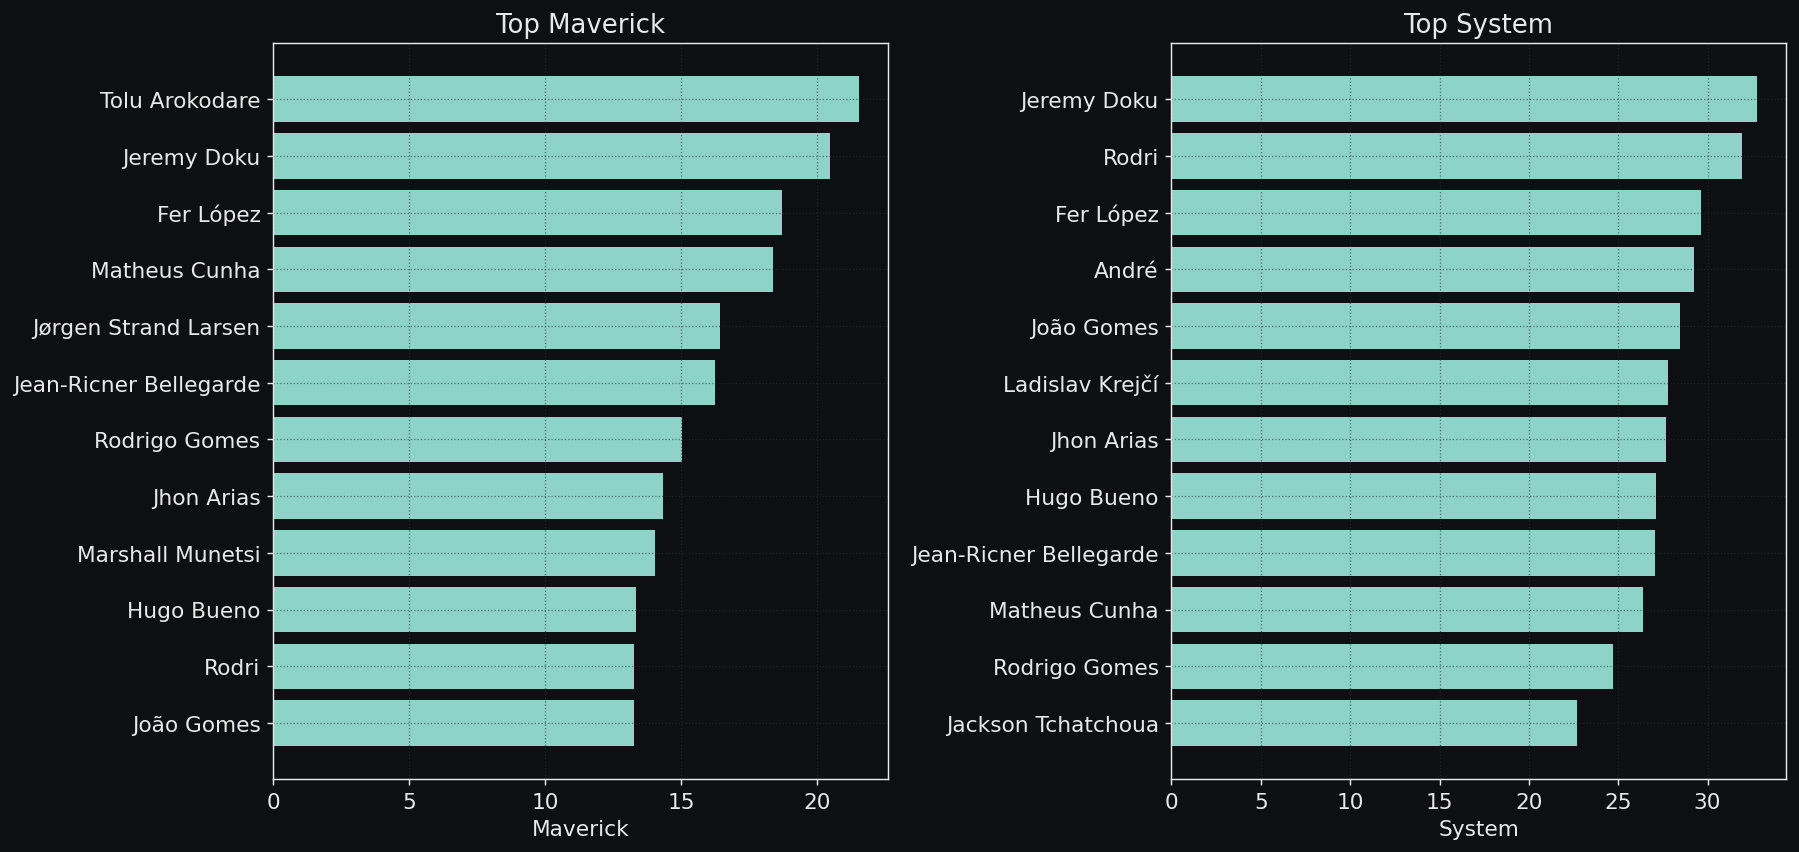

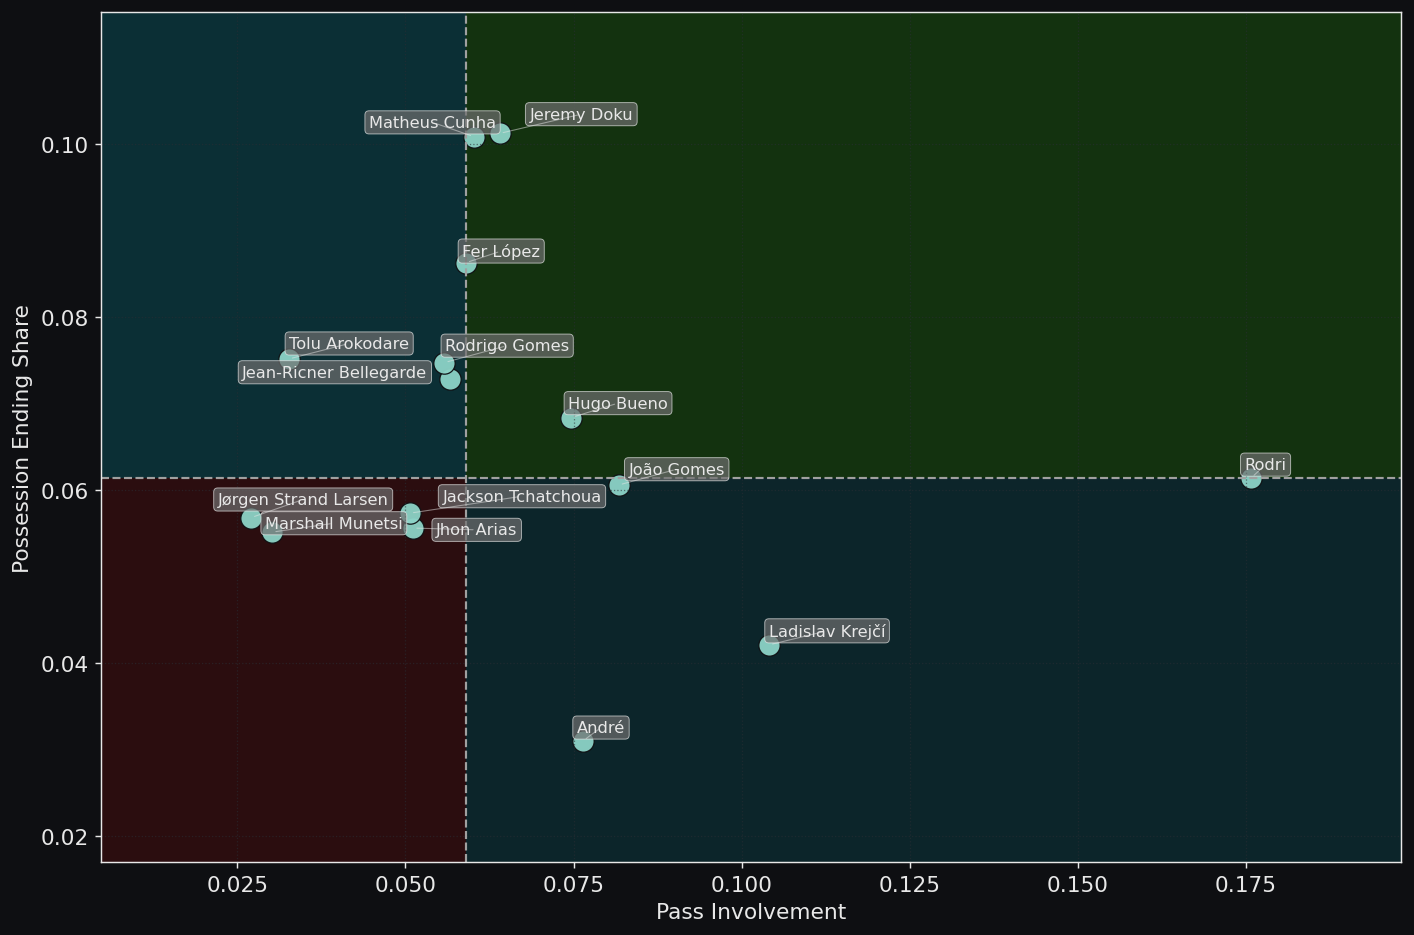

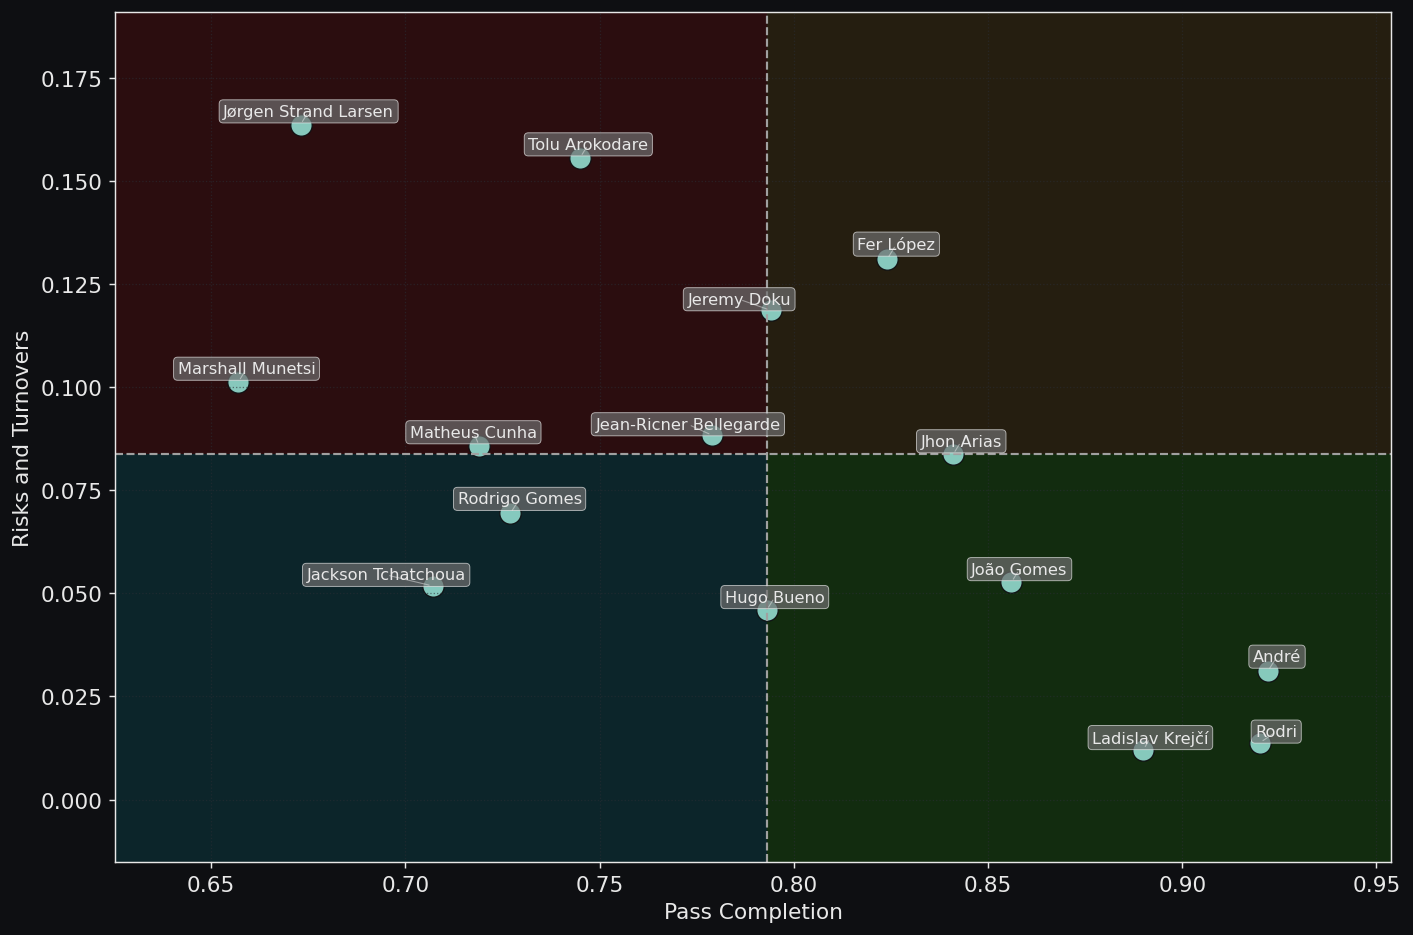

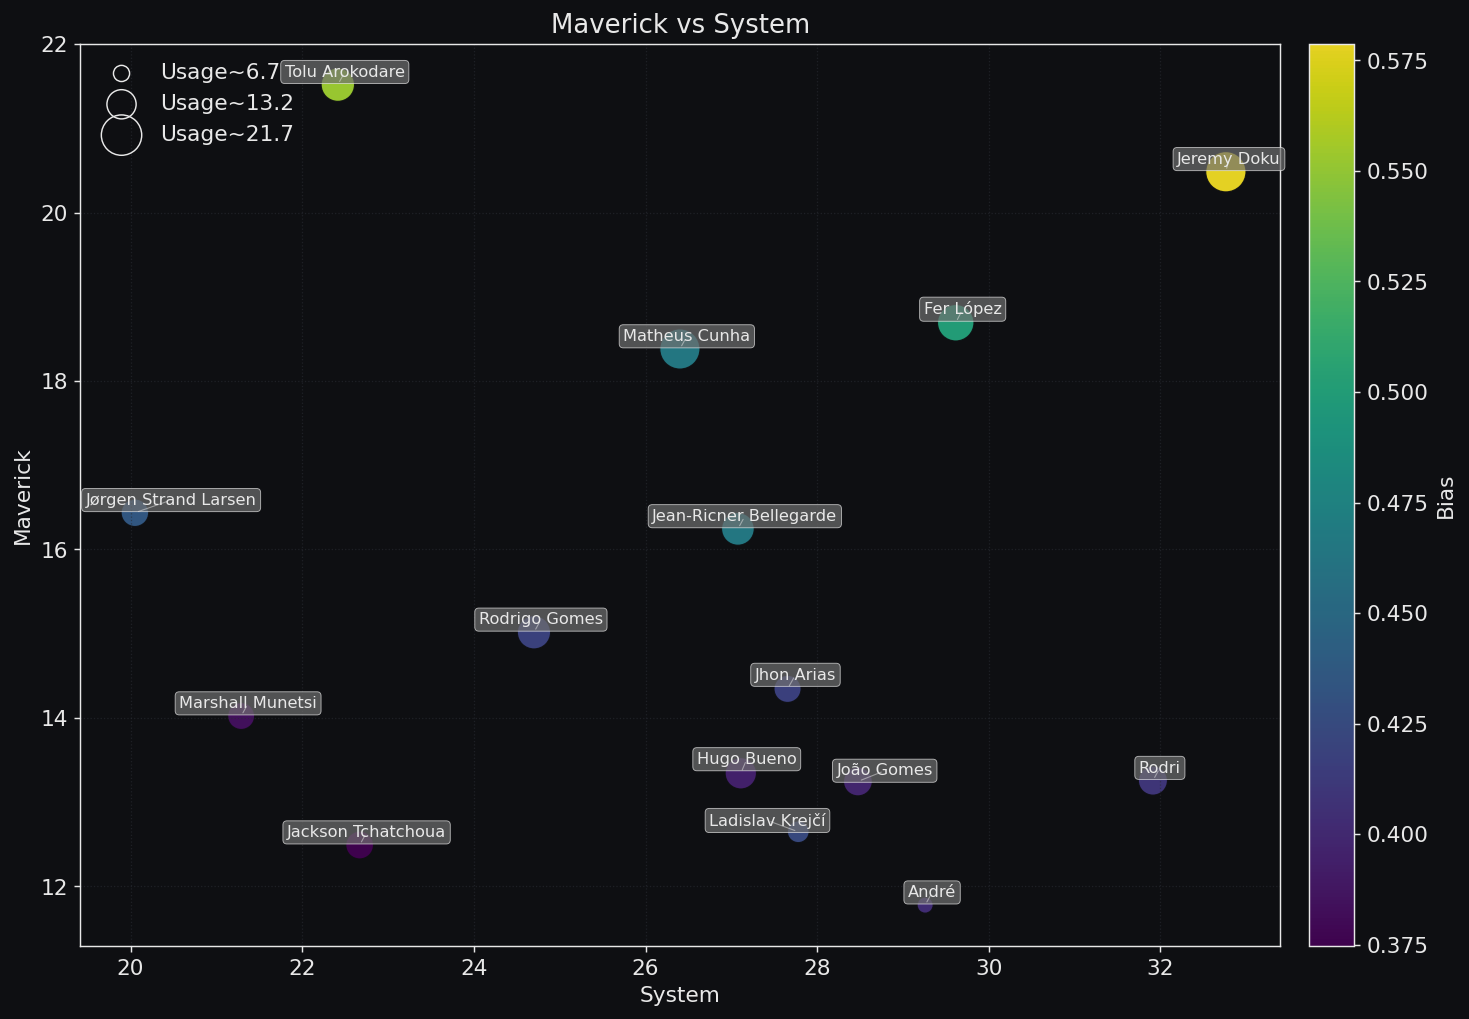

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

try:
    from adjustText import adjust_text
    _USE_ADJUST_TEXT = True
except Exception:
    _USE_ADJUST_TEXT = False


FILE  = "cs6.xlsx"
SHEET = "FINAL"

BG_COLOR = "#0e0f12"
FG_COLOR = "#e8e8e8"
GRID_COLOR = "#2a2d34"
ACCENT = "#f7a400"
REG_LINE_COLOR = "#a0a0a0"

CURR_COLOR = "#f7a400"
REF_COLOR  = "#40c9ff"

def _norm(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9+]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def resolve_column(df, candidates, required=True):
    norm_map = {_norm(c): c for c in df.columns}
    all_norm = list(norm_map.keys())
    for cand in candidates:
        c = _norm(cand)
        if c in norm_map:
            return norm_map[c]
    for cand in candidates:
        c = _norm(cand)
        for hdr in all_norm:
            if c == hdr or c in hdr or hdr in c:
                return norm_map[hdr]
    if required:
        raise KeyError(f"Could not resolve column for {candidates}. Available: {list(df.columns)}")
    return None

def apply_dark_style():
    plt.style.use("dark_background")
    plt.rcParams.update({
        "figure.facecolor": BG_COLOR,
        "axes.facecolor": BG_COLOR,
        "axes.edgecolor": FG_COLOR,
        "axes.labelcolor": FG_COLOR,
        "xtick.color": FG_COLOR,
        "ytick.color": FG_COLOR,
        "text.color": FG_COLOR,
        "grid.color": GRID_COLOR,
        "font.size": 12
    })

def annotate_points(ax, x, y, labels, fontsize=9):
    texts = []
    for xi, yi, lab in zip(x, y, labels):
        texts.append(ax.text(
            xi, yi, str(lab),
            fontsize=fontsize, ha="center", va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="#6f6f6f",
                      alpha=0.70, edgecolor=FG_COLOR, linewidth=0.5)
        ))
    if _USE_ADJUST_TEXT and len(texts) > 0:
        adjust_text(
            texts, only_move={'points': 'y', 'text': 'xy'}, ax=ax,
            arrowprops=dict(arrowstyle="-", lw=0.6, color=FG_COLOR, alpha=0.5),
            expand_points=(1.05, 1.15), expand_text=(1.05, 1.15),
            force_points=0.2, force_text=0.2, lim=400
        )

def safe_minmax(a):
    a = np.asarray(a, dtype=float)
    amin, amax = np.nanmin(a), np.nanmax(a)
    if not np.isfinite(amin) or not np.isfinite(amax) or amax <= amin:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin)

def load_final():
    if not os.path.exists(FILE):
        raise FileNotFoundError(f"Couldn't find {FILE} in the working directory.")

    df = pd.read_excel(FILE, sheet_name=SHEET).copy()

    COLS = {
        "NAME": ["Name", "Player"],
        "MAV": ["Maverick"],
        "SYS": ["System"],
        "USAGE": ["Usage"],       
        "USAGEI": ["UsageI"],   
        "BIAS": ["Bias"],
        "THREAT": ["Threat"],
        "RISK": ["Risk"],
        "CIRC": ["Circulation"],     
        "SEC": ["Security"],        
        "PROG": ["Progression"],
        "DEF": ["Defence", "Defense"],
        "STATE": ["State"], 
    }

    resolved = {}
    for k, cands in COLS.items():
        resolved[k] = resolve_column(df, cands, required=(k not in {"STATE"}))

    num_cols = [resolved[k] for k in resolved if k not in {"NAME", "STATE"} and resolved[k] is not None]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    keep = [resolved["NAME"], resolved["MAV"], resolved["SYS"]]
    df = df.dropna(subset=keep)

    return df, resolved


def plot_rankings(df, C, top_n=12):
    apply_dark_style()

    name = C["NAME"]; mav = C["MAV"]; sys = C["SYS"]

    top_mav = df.sort_values(mav, ascending=False).head(top_n)
    top_sys = df.sort_values(sys, ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=130)
    # fig.suptitle("Rankings (Top Players)", y=0.98)

    ax = axes[0]
    ax.barh(top_mav[name][::-1], top_mav[mav][::-1])
    ax.set_title("Top Maverick")
    ax.set_xlabel("Maverick")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    ax = axes[1]
    ax.barh(top_sys[name][::-1], top_sys[sys][::-1])
    ax.set_title("Top System")
    ax.set_xlabel("System")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_style_balance(df, C):
    apply_dark_style()

    name = C["NAME"]; mav = C["MAV"]; sys = C["SYS"]
    work = df.copy()
    work["Balance"] = work[mav] - work[sys]
    work = work.sort_values("Balance", ascending=True)

    fig, ax = plt.subplots(figsize=(12, 7), dpi=130)
    vals = work["Balance"].values
    ylab = work[name].astype(str).values

    ax.axvline(0, color=REG_LINE_COLOR, linestyle="--", linewidth=1.2)
    ax.barh(ylab, vals)

    ax.set_title("Style Balance (Maverick − System)")
    ax.set_xlabel("Positive = Maverick-leaning, Negative = System-leaning")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    ax.text(ax.get_xlim()[0]*0.98, len(ylab)-0.2, "More System", ha="left", va="top", color="#9a9a9a")
    ax.text(ax.get_xlim()[1]*0.98, len(ylab)-0.2, "More Maverick", ha="right", va="top", color="#9a9a9a")

    plt.tight_layout()
    plt.show()


def plot_usage_vs_circulation(df, C):
    apply_dark_style()

    name = C["NAME"]; usage = C["USAGE"]; circ = C["CIRC"]

    work = df.dropna(subset=[usage, circ]).copy()
    x = work[circ].values
    y = work[usage].values

    x_med = np.median(x)
    y_med = np.median(y)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xpad = (xmax - xmin) * 0.15 if xmax > xmin else 0.02
    ypad = (ymax - ymin) * 0.20 if ymax > ymin else 0.02

    fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

    ax.add_patch(Rectangle((xmin - xpad, y_med), (x_med - (xmin - xpad)), (ymax + ypad - y_med),
                           facecolor="#00eaff", alpha=0.15, edgecolor="none"))
    ax.add_patch(Rectangle((x_med, y_med), (xmax + xpad - x_med), (ymax + ypad - y_med),
                           facecolor="#33ff00", alpha=0.15, edgecolor="none"))
    ax.add_patch(Rectangle((xmin - xpad, ymin - ypad), (x_med - (xmin - xpad)), (y_med - (ymin - ypad)),
                           facecolor="#ff0000", alpha=0.12, edgecolor="none"))
    ax.add_patch(Rectangle((x_med, ymin - ypad), (xmax + xpad - x_med), (y_med - (ymin - ypad)),
                           facecolor="#00eaff", alpha=0.10, edgecolor="none"))

    ax.axvline(x_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)
    ax.axhline(y_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)

    ax.scatter(x, y, s=140, edgecolors=BG_COLOR, linewidths=0.7, alpha=0.95)

    annotate_points(ax, x, y, work[name].values, fontsize=9)

    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)
    ax.set_xlabel("Pass Involvement")
    ax.set_ylabel("Possession Ending Share")
    # ax.set_title("Usage vs Circulation")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    plt.tight_layout(rect=[0.06, 0.04, 0.98, 0.96])
    plt.show()



def plot_risk_vs_security(df, C):
    apply_dark_style()

    name = C["NAME"]; risk = C["RISK"]; sec = C["SEC"]
    work = df.dropna(subset=[risk, sec]).copy()

    x = work[sec].values
    y = work[risk].values

    x_med = np.median(x)
    y_med = np.median(y)

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xpad = (xmax - xmin) * 0.12 if xmax > xmin else 0.02
    ypad = (ymax - ymin) * 0.18 if ymax > ymin else 0.02

    fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

    ax.add_patch(Rectangle((xmin - xpad, y_med), (x_med - (xmin - xpad)), (ymax + ypad - y_med),
                           facecolor="#ff0000", alpha=0.12, edgecolor="none"))
    ax.add_patch(Rectangle((x_med, y_med), (xmax + xpad - x_med), (ymax + ypad - y_med),
                           facecolor="#f7a400", alpha=0.10, edgecolor="none"))
    ax.add_patch(Rectangle((xmin - xpad, ymin - ypad), (x_med - (xmin - xpad)), (y_med - (ymin - ypad)),
                           facecolor="#00eaff", alpha=0.10, edgecolor="none"))
    ax.add_patch(Rectangle((x_med, ymin - ypad), (xmax + xpad - x_med), (y_med - (ymin - ypad)),
                           facecolor="#33ff00", alpha=0.12, edgecolor="none"))

    ax.axvline(x_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)
    ax.axhline(y_med, linestyle="--", color=REG_LINE_COLOR, linewidth=1.2)

    ax.scatter(x, y, s=140, edgecolors=BG_COLOR, linewidths=0.7, alpha=0.95)
    annotate_points(ax, x, y, work[name].values, fontsize=9)

    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)
    ax.set_xlabel("Pass Completion")
    ax.set_ylabel("Risks and Turnovers")
    # ax.set_title("Risk vs Security")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    plt.tight_layout(rect=[0.06, 0.04, 0.98, 0.96])
    plt.show()


def plot_mav_sys_bubble(df, C):
    apply_dark_style()

    name = C["NAME"]; mav = C["MAV"]; sys = C["SYS"]
    usageI = C["USAGEI"]; bias = C["BIAS"]

    work = df.dropna(subset=[mav, sys, usageI, bias]).copy()
    x = work[sys].values
    y = work[mav].values

    s = work[usageI].values
    s_norm = safe_minmax(s)
    sizes = 80 + 420 * s_norm

    fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

    sc = ax.scatter(
        x, y,
        s=sizes,
        c=work[bias].values,
        alpha=0.90,
        edgecolors=BG_COLOR,
        linewidths=0.7
    )

    annotate_points(ax, x, y, work[name].values, fontsize=9)

    ax.set_xlabel("System")
    ax.set_ylabel("Maverick")
    ax.set_title("Maverick vs System")
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.6)

    cb = plt.colorbar(sc, ax=ax, pad=0.02)
    cb.set_label("Bias")

    # bubble legend
    # pick a few representative sizes
    for val in [np.nanmin(s), np.nanmedian(s), np.nanmax(s)]:
        val = float(val)
        sn = safe_minmax([val, np.nanmin(s), np.nanmax(s)])[0]
        ax.scatter([], [], s=80 + 420*sn, c="none", edgecolors=FG_COLOR, linewidths=0.8,
                   label=f"Usage~{val:.1f}")
    ax.legend(frameon=False, loc="upper left")

    plt.tight_layout()
    plt.show()


df, C = load_final()

plot_rankings(df, C, top_n=min(12, len(df)))
# plot_style_balance(df, C)
plot_usage_vs_circulation(df, C)
plot_risk_vs_security(df, C)
plot_mav_sys_bubble(df, C)
